# Misclassification Analysis

This notebook loads a trained model checkpoint and analyzes misclassifications to understand where the model is struggling.

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import sys
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from collections import defaultdict

# Add src to path
project_root = Path().absolute().parent
sys.path.append(str(project_root))

from src.datasets import ProductDataset
from src.transforms import get_transforms
from src.model import get_model
from src.config import ConfigLoader

print(f"Project root: {project_root}")
print(f"Available checkpoints: {list(Path(project_root / 'checkpoints').glob('*.pth'))}")

Project root: /home/ctw03455/product_classification
Available checkpoints: [PosixPath('/home/ctw03455/product_classification/checkpoints/best_model_fast_experiment.pth')]


## Load Model and Configuration

In [2]:
# Configuration
CHECKPOINT_PATH = project_root / "checkpoints" / "best_model_fast_experiment.pth"  # Change this to your checkpoint
DATA_DIR = project_root / "data"
VAL_DIR = DATA_DIR / "validation"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")
print(f"Loading checkpoint: {CHECKPOINT_PATH}")

# Load checkpoint
if CHECKPOINT_PATH.exists():
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    config = checkpoint.get('config', None)
    print(f"Checkpoint epoch: {checkpoint.get('epoch', 'unknown')}")
    print(f"Best validation accuracy: {checkpoint.get('best_val_acc', 'unknown'):.4f}")
else:
    print(f"Checkpoint not found: {CHECKPOINT_PATH}")
    # Fallback to base config
    loader = ConfigLoader(project_root / "configs")
    config = loader.load_config("base_config")
    checkpoint = None

Using device: cuda
Loading checkpoint: /home/ctw03455/product_classification/checkpoints/best_model_fast_experiment.pth
Checkpoint epoch: 2
Best validation accuracy: 0.4785


In [3]:
# Create validation dataset
val_dataset = ProductDataset(
    str(VAL_DIR), 
    transform=get_transforms(train=False, type='config', config=config), 
    use_mask=False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=4
)

# Get class names
class_names = list(val_dataset.class_to_idx.keys())
idx_to_class = {v: k for k, v in val_dataset.class_to_idx.items()}
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")
print(f"Validation samples: {len(val_dataset)}")

Number of classes: 9
Classes: ['NestumMel', 'amaciador_confort', 'bolachasRicanela_Quetara', 'cereaisAllbran_kellog', 'detergente_Woolite', 'lixivia_domestos', 'papelHigienico_Scottex', 'pensoHigienico_Evax', 'tostas_tostagrill']
Validation samples: 163


In [4]:
# Create and load model
model = get_model(num_classes, config)
model = model.to(DEVICE)

if checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("✓ Model weights loaded from checkpoint")
else:
    print("⚠️ Using untrained model (no checkpoint loaded)")

model.eval()
print(f"Model architecture: {config['model']['backbone']}")

✓ Model weights loaded from checkpoint
Model architecture: resnet18


## Evaluate Model and Collect Misclassifications

In [10]:
# Evaluate model and collect predictions
all_predictions = []
all_true_labels = []
all_probabilities = []
all_image_paths = []
misclassified_samples = []

model.eval()
correct = 0
total = 0

print("Evaluating model...")

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Get predictions
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        # Collect results
        batch_correct = (predicted == labels)
        correct += batch_correct.sum().item()
        total += labels.size(0)
        
        # Store predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())
        
        # Collect misclassified samples
        for i in range(len(labels)):
            sample_idx = batch_idx * val_loader.batch_size + i
            if sample_idx < len(val_dataset):
                image_path = val_dataset.samples[sample_idx][0]
                all_image_paths.append(image_path)
                
                if not batch_correct[i]:
                    misclassified_samples.append({
                        'image_path': image_path,
                        'true_label': labels[i].item(),
                        'predicted_label': predicted[i].item(),
                        'true_class': idx_to_class[labels[i].item()],
                        'predicted_class': idx_to_class[predicted[i].item()],
                        'confidence': probabilities[i][predicted[i]].item(),
                        'true_confidence': probabilities[i][labels[i]].item()
                    })

# Calculate accuracy
accuracy = correct / total
print(f"\nValidation Accuracy: {accuracy:.4f} ({correct}/{total})")
print(f"Number of misclassifications: {len(misclassified_samples)}")

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)
all_probabilities = np.array(all_probabilities)

Evaluating model...

Validation Accuracy: 0.4785 (78/163)
Number of misclassifications: 85


## Confusion Matrix Analysis

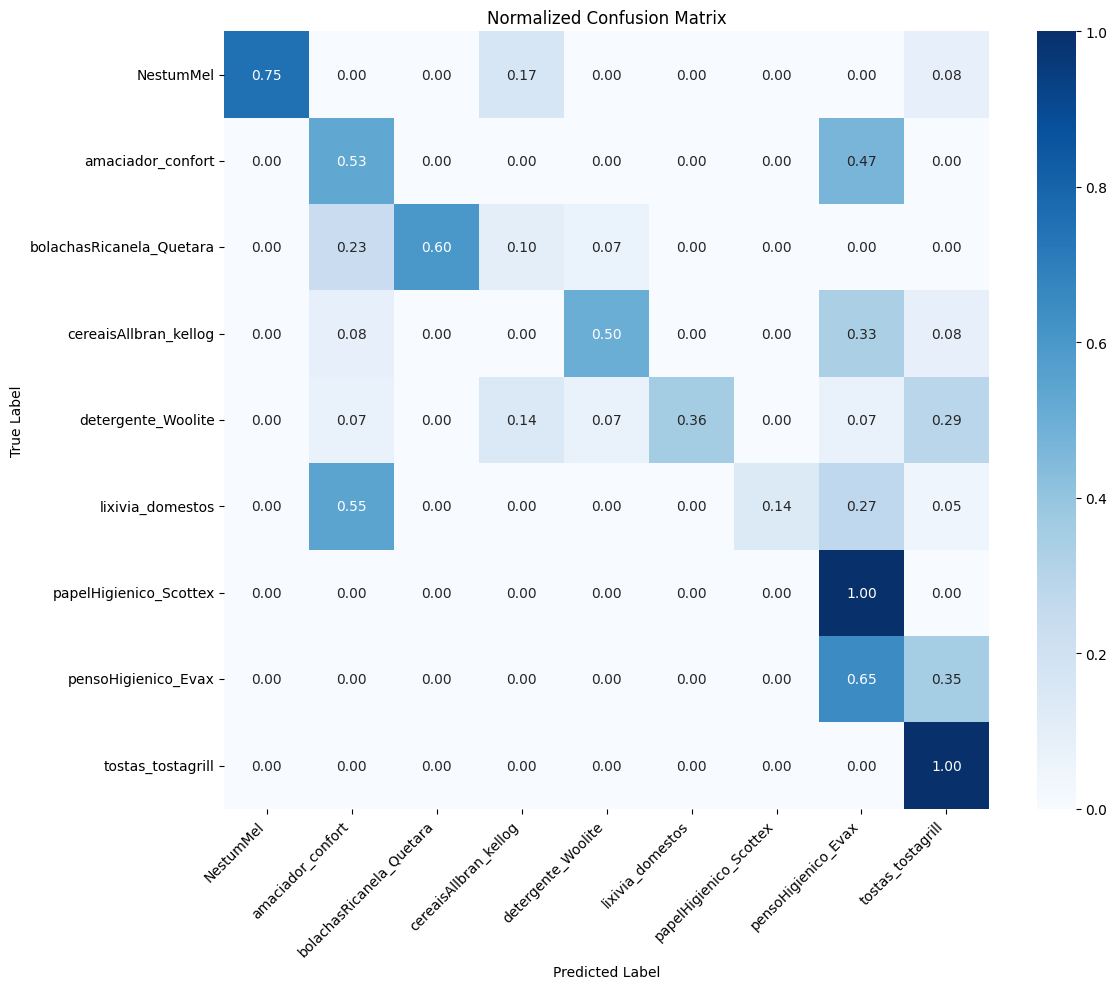


Classification Report:
                          precision    recall  f1-score   support

               NestumMel       1.00      0.75      0.86        24
       amaciador_confort       0.28      0.53      0.36        15
bolachasRicanela_Quetara       1.00      0.60      0.75        30
   cereaisAllbran_kellog       0.00      0.00      0.00        12
      detergente_Woolite       0.11      0.07      0.09        14
        lixivia_domestos       0.00      0.00      0.00        22
  papelHigienico_Scottex       0.00      0.00      0.00         7
     pensoHigienico_Evax       0.31      0.65      0.42        17
       tostas_tostagrill       0.61      1.00      0.76        22

                accuracy                           0.48       163
               macro avg       0.37      0.40      0.36       163
            weighted avg       0.48      0.48      0.45       163



In [11]:
# Create confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, 
            annot=True, 
            fmt='.2f', 
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(all_true_labels, all_predictions, target_names=class_names))

## Most Common Misclassification Patterns

Most Common Misclassification Patterns:
lixivia_domestos → amaciador_confort      12 ( 14.1%)
amaciador_confort → pensoHigienico_Evax    7 (  8.2%)
bolachasRicanela_Quetara → amaciador_confort   7 (  8.2%)
papelHigienico_Scottex → pensoHigienico_Evax   7 (  8.2%)
cereaisAllbran_kellog → detergente_Woolite   6 (  7.1%)
lixivia_domestos → pensoHigienico_Evax     6 (  7.1%)
pensoHigienico_Evax → tostas_tostagrill    6 (  7.1%)
detergente_Woolite → lixivia_domestos      5 (  5.9%)
NestumMel → cereaisAllbran_kellog          4 (  4.7%)
cereaisAllbran_kellog → pensoHigienico_Evax   4 (  4.7%)
detergente_Woolite → tostas_tostagrill     4 (  4.7%)
bolachasRicanela_Quetara → cereaisAllbran_kellog   3 (  3.5%)
lixivia_domestos → papelHigienico_Scottex   3 (  3.5%)
NestumMel → tostas_tostagrill              2 (  2.4%)
bolachasRicanela_Quetara → detergente_Woolite   2 (  2.4%)


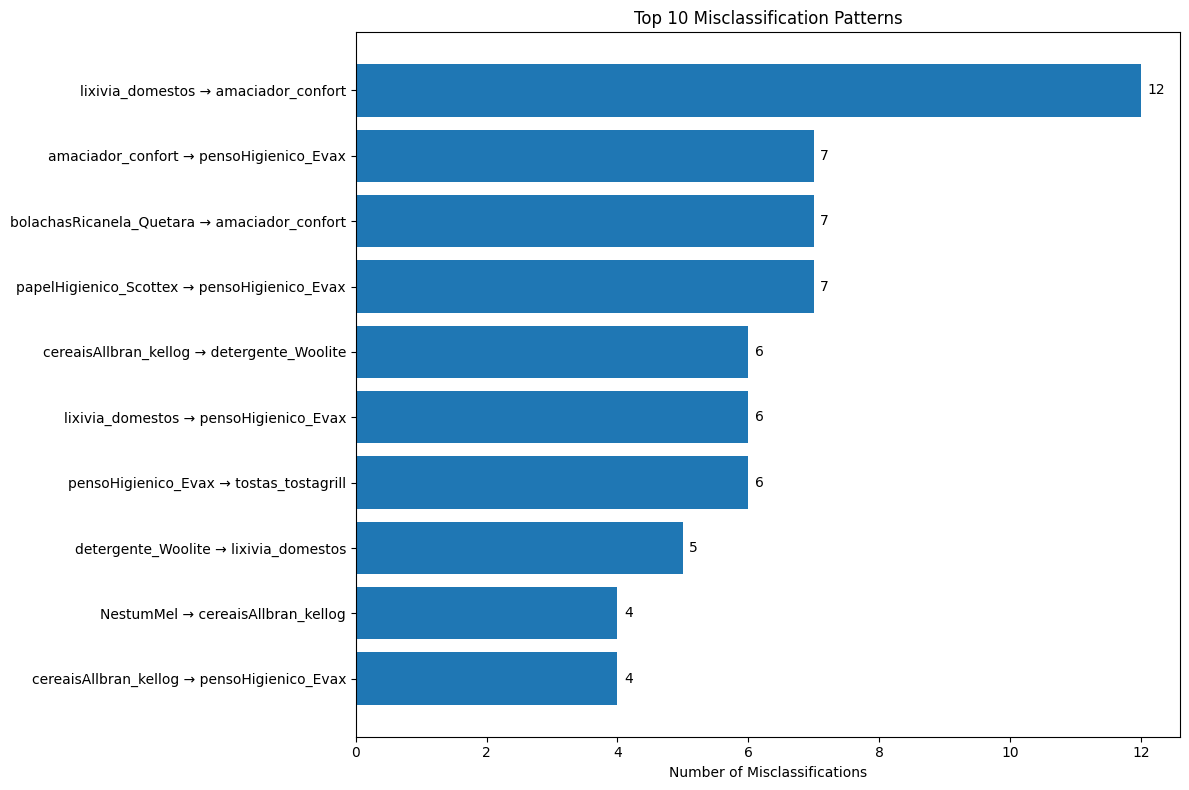

In [12]:
# Analyze misclassification patterns
misclass_patterns = defaultdict(int)
confidence_analysis = []

for sample in misclassified_samples:
    pattern = f"{sample['true_class']} → {sample['predicted_class']}"
    misclass_patterns[pattern] += 1
    confidence_analysis.append({
        'pattern': pattern,
        'confidence': sample['confidence'],
        'true_confidence': sample['true_confidence']
    })

# Sort patterns by frequency
sorted_patterns = sorted(misclass_patterns.items(), key=lambda x: x[1], reverse=True)

print("Most Common Misclassification Patterns:")
print("=" * 50)
for pattern, count in sorted_patterns[:15]:  # Top 15
    percentage = (count / len(misclassified_samples)) * 100
    print(f"{pattern:<40} {count:>3} ({percentage:>5.1f}%)")

# Plot top misclassification patterns
top_10_patterns = sorted_patterns[:10]
patterns, counts = zip(*top_10_patterns)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(patterns)), counts)
plt.yticks(range(len(patterns)), patterns)
plt.xlabel('Number of Misclassifications')
plt.title('Top 10 Misclassification Patterns')
plt.gca().invert_yaxis()

# Add count labels on bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
             str(count), va='center')

plt.tight_layout()
plt.show()

## Confidence Analysis of Misclassifications

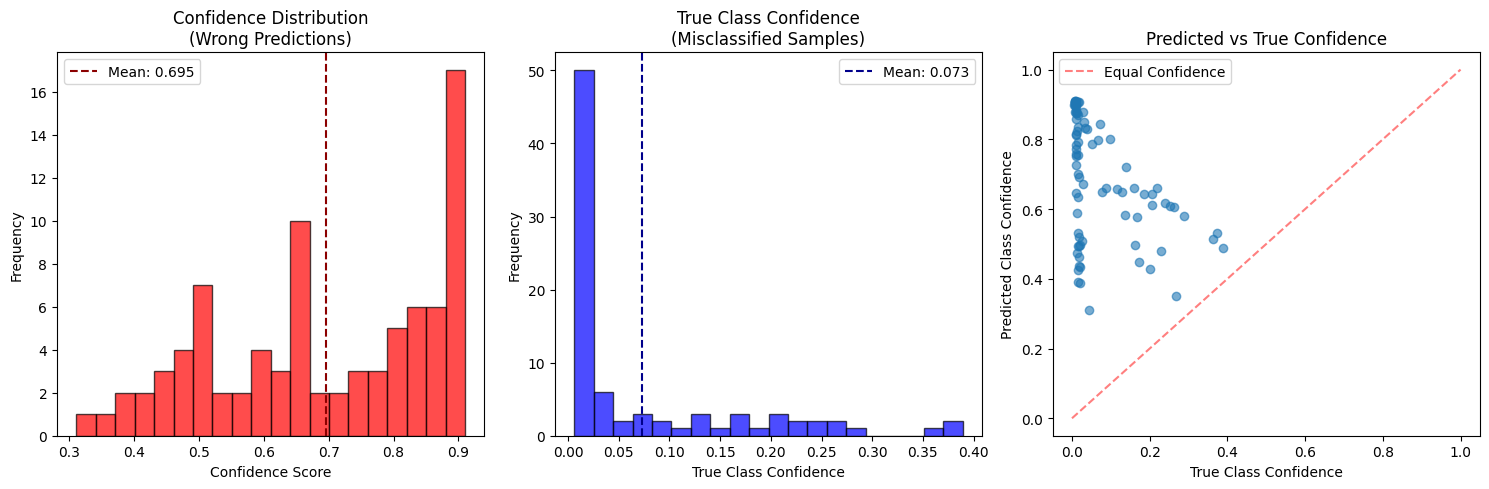

Average confidence for wrong predictions: 0.695
Average true class confidence for misclassifications: 0.073
High confidence mistakes (>0.8): 32


In [13]:
# Analyze confidence scores
confidences = [sample['confidence'] for sample in misclassified_samples]
true_confidences = [sample['true_confidence'] for sample in misclassified_samples]

plt.figure(figsize=(15, 5))

# Plot 1: Distribution of confidence scores for wrong predictions
plt.subplot(1, 3, 1)
plt.hist(confidences, bins=20, alpha=0.7, color='red', edgecolor='black')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Distribution\n(Wrong Predictions)')
plt.axvline(np.mean(confidences), color='darkred', linestyle='--', 
           label=f'Mean: {np.mean(confidences):.3f}')
plt.legend()

# Plot 2: Distribution of true class confidence for misclassifications
plt.subplot(1, 3, 2)
plt.hist(true_confidences, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('True Class Confidence')
plt.ylabel('Frequency')
plt.title('True Class Confidence\n(Misclassified Samples)')
plt.axvline(np.mean(true_confidences), color='darkblue', linestyle='--',
           label=f'Mean: {np.mean(true_confidences):.3f}')
plt.legend()

# Plot 3: Scatter plot of predicted vs true confidence
plt.subplot(1, 3, 3)
plt.scatter(true_confidences, confidences, alpha=0.6)
plt.xlabel('True Class Confidence')
plt.ylabel('Predicted Class Confidence')
plt.title('Predicted vs True Confidence')
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Equal Confidence')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Average confidence for wrong predictions: {np.mean(confidences):.3f}")
print(f"Average true class confidence for misclassifications: {np.mean(true_confidences):.3f}")
print(f"High confidence mistakes (>0.8): {sum(1 for c in confidences if c > 0.8)}")

## Visualize Misclassified Images


Showing misclassified samples...


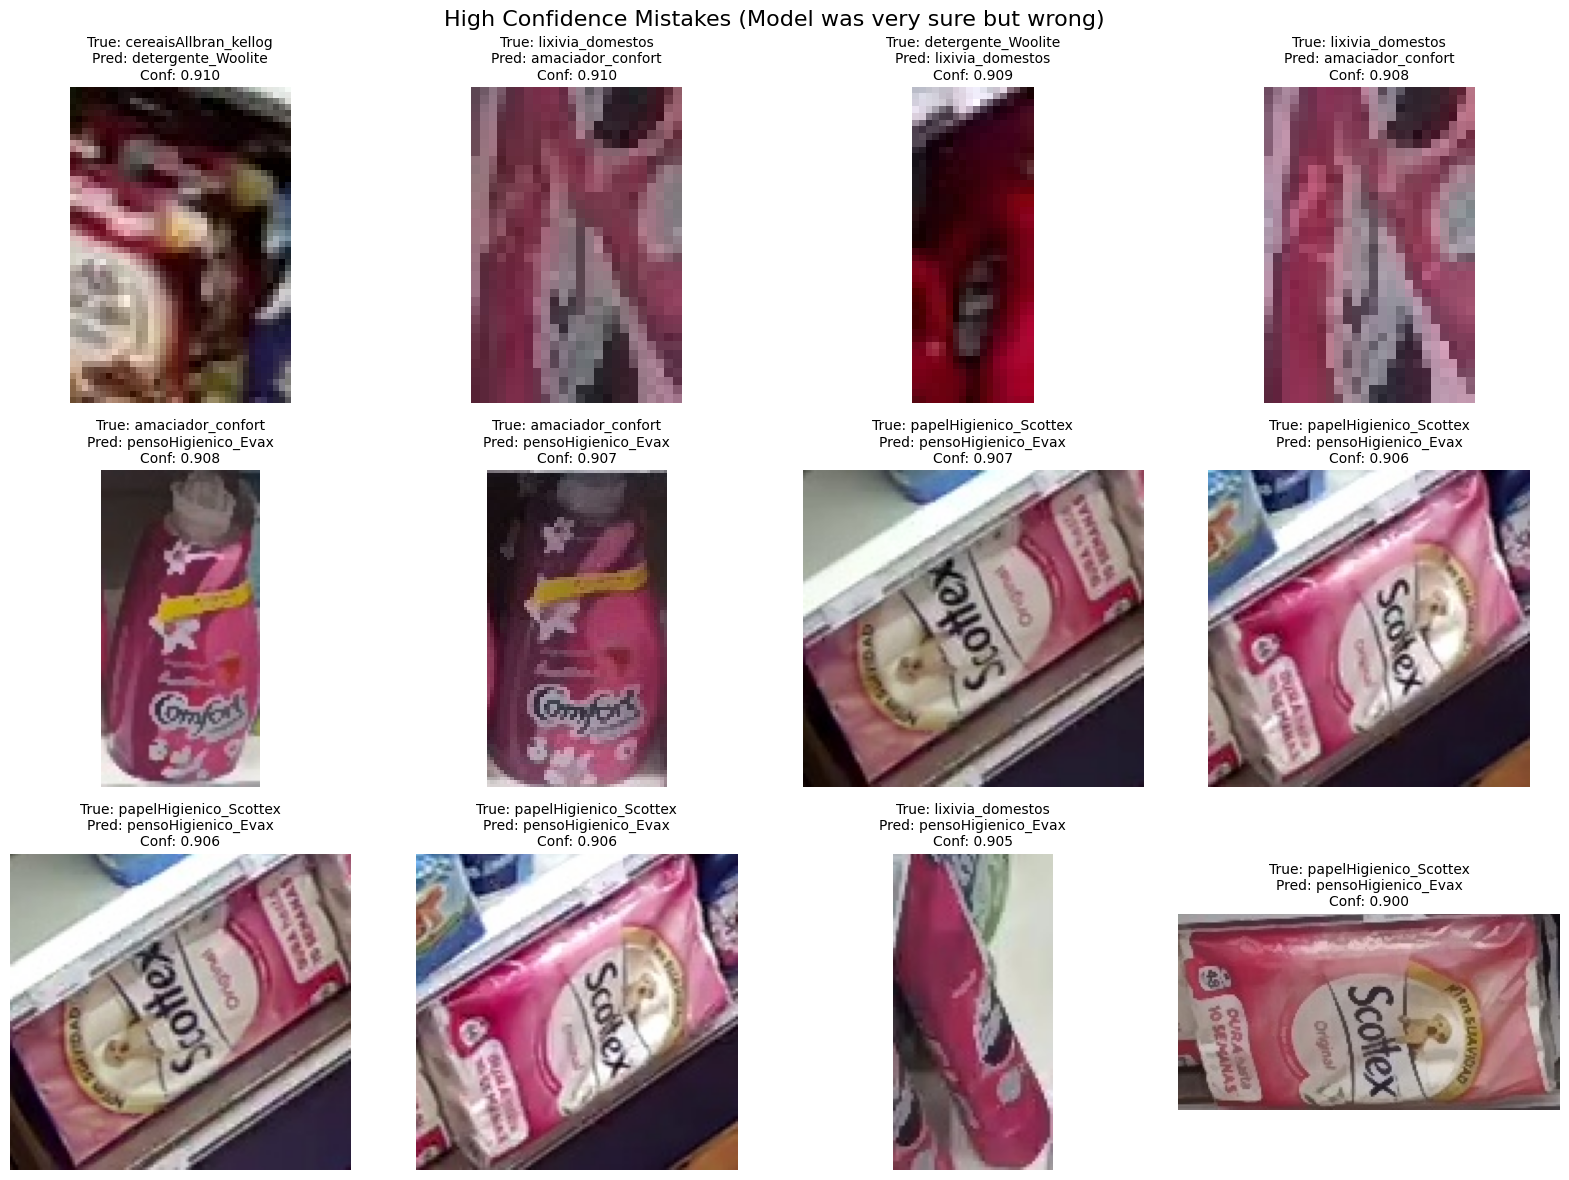

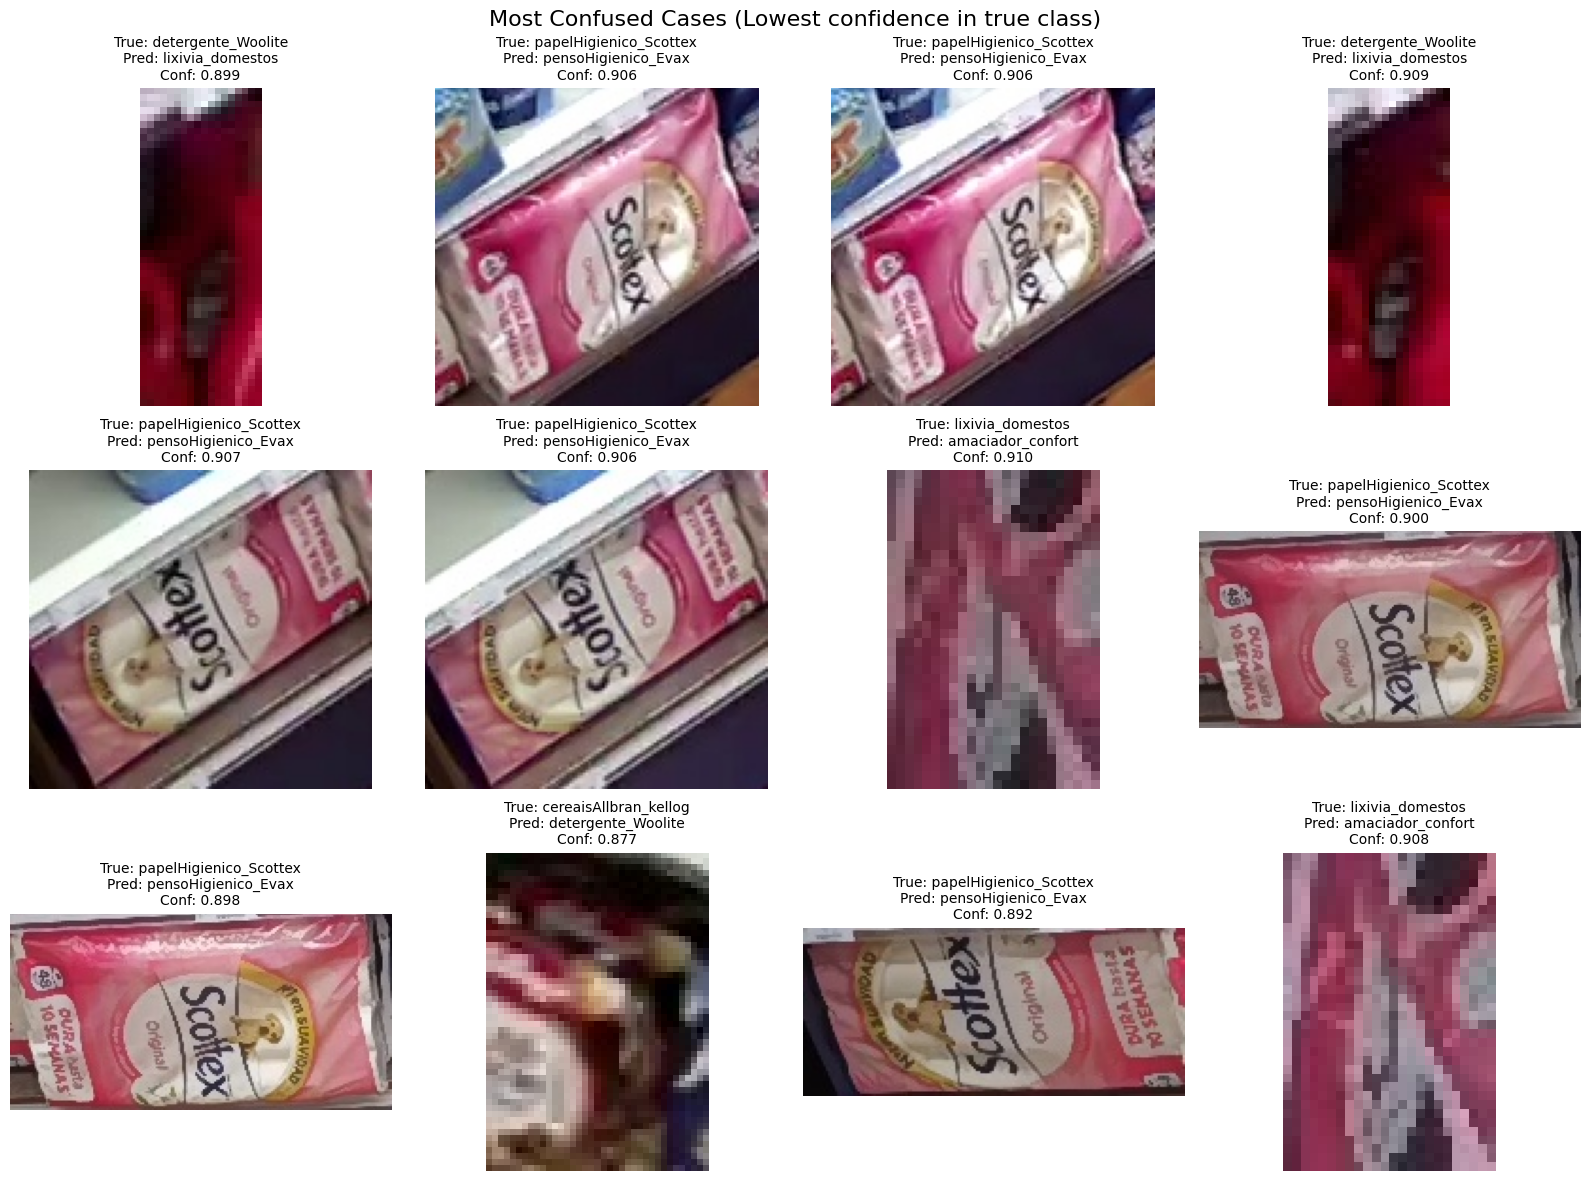

In [14]:
def plot_misclassified_samples(samples, title, num_samples=12):
    """Plot a grid of misclassified samples."""
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle(title, fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i < len(samples) and i < num_samples:
            sample = samples[i]
            
            # Load and display image
            try:
                img = Image.open(sample['image_path']).convert('RGB')
                ax.imshow(img)
                
                # Create title with prediction info
                title_text = (f"True: {sample['true_class']}\n"
                             f"Pred: {sample['predicted_class']}\n"
                             f"Conf: {sample['confidence']:.3f}")
                
                ax.set_title(title_text, fontsize=10)
                ax.axis('off')
                
            except Exception as e:
                ax.text(0.5, 0.5, f'Error loading\n{sample["image_path"]}', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Sort misclassified samples by confidence (highest first)
high_confidence_mistakes = sorted(misclassified_samples, 
                                key=lambda x: x['confidence'], reverse=True)

# Sort by lowest true confidence (most confused cases)
most_confused = sorted(misclassified_samples, 
                      key=lambda x: x['true_confidence'])

print(f"\nShowing misclassified samples...")

# Plot high confidence mistakes
plot_misclassified_samples(high_confidence_mistakes[:12], 
                          "High Confidence Mistakes (Model was very sure but wrong)")

# Plot most confused cases
plot_misclassified_samples(most_confused[:12], 
                          "Most Confused Cases (Lowest confidence in true class)")

## Per-Class Error Analysis

Per-Class Accuracy:
cereaisAllbran_kellog     0.000 (12 samples)
lixivia_domestos          0.000 (22 samples)
papelHigienico_Scottex    0.000 (7 samples)
detergente_Woolite        0.071 (14 samples)
amaciador_confort         0.533 (15 samples)
bolachasRicanela_Quetara  0.600 (30 samples)
pensoHigienico_Evax       0.647 (17 samples)
NestumMel                 0.750 (24 samples)
tostas_tostagrill         1.000 (22 samples)


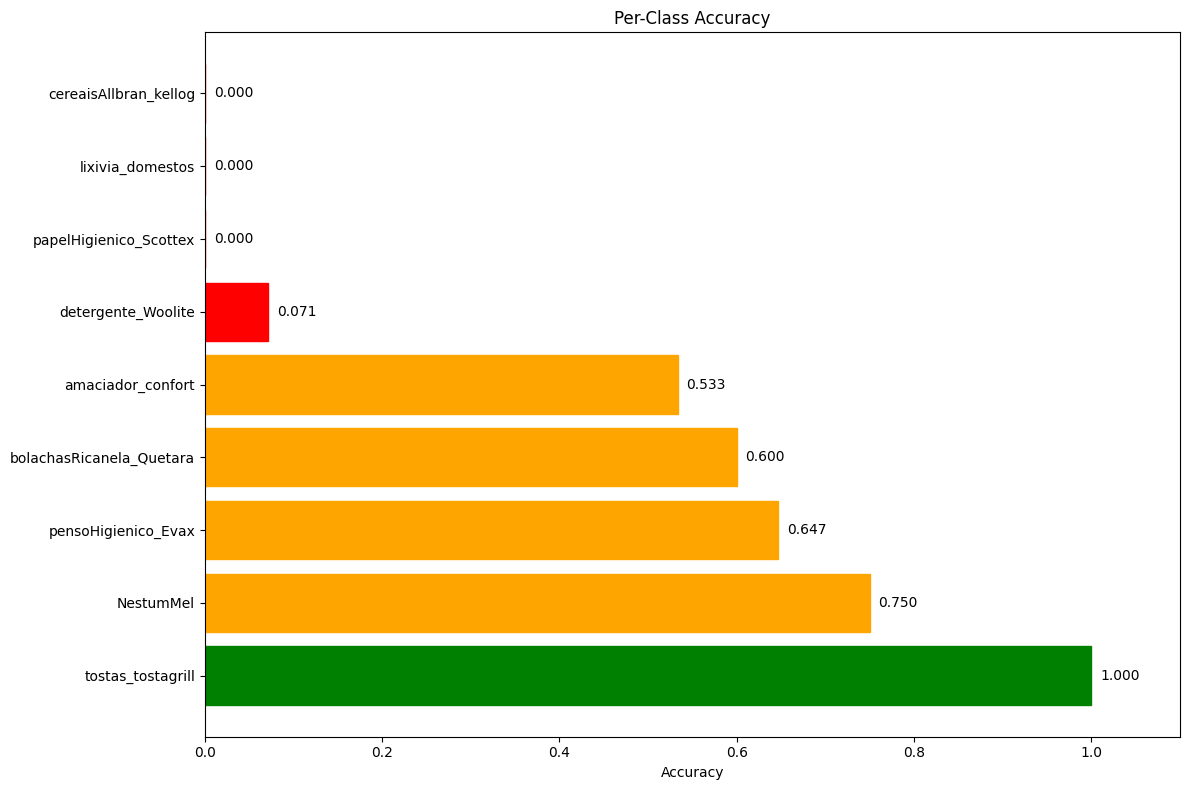


Worst Performing Classes and Their Common Mistakes:

cereaisAllbran_kellog (Accuracy: 0.000):
  → Often confused with detergente_Woolite (6 times)
  → Often confused with pensoHigienico_Evax (4 times)
  → Often confused with amaciador_confort (1 times)

lixivia_domestos (Accuracy: 0.000):
  → Often confused with amaciador_confort (12 times)
  → Often confused with pensoHigienico_Evax (6 times)
  → Often confused with papelHigienico_Scottex (3 times)

papelHigienico_Scottex (Accuracy: 0.000):
  → Often confused with pensoHigienico_Evax (7 times)

detergente_Woolite (Accuracy: 0.071):
  → Often confused with lixivia_domestos (5 times)
  → Often confused with tostas_tostagrill (4 times)
  → Often confused with cereaisAllbran_kellog (2 times)

amaciador_confort (Accuracy: 0.533):
  → Often confused with pensoHigienico_Evax (7 times)


In [15]:
# Per-class accuracy analysis
class_accuracy = {}
class_errors = defaultdict(list)

for i, class_name in enumerate(class_names):
    # True samples for this class
    true_mask = all_true_labels == i
    if true_mask.sum() > 0:
        class_predictions = all_predictions[true_mask]
        class_accuracy[class_name] = (class_predictions == i).mean()
        
        # Collect errors for this class
        wrong_predictions = class_predictions[class_predictions != i]
        for wrong_pred in wrong_predictions:
            class_errors[class_name].append(idx_to_class[wrong_pred])

# Sort classes by accuracy
sorted_accuracy = sorted(class_accuracy.items(), key=lambda x: x[1])

print("Per-Class Accuracy:")
print("=" * 40)
for class_name, acc in sorted_accuracy:
    num_samples = (all_true_labels == val_dataset.class_to_idx[class_name]).sum()
    print(f"{class_name:<25} {acc:.3f} ({num_samples} samples)")

# Plot per-class accuracy
classes, accuracies = zip(*sorted_accuracy)
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(classes)), accuracies)
plt.yticks(range(len(classes)), classes)
plt.xlabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.gca().invert_yaxis()

# Color bars based on accuracy
for bar, acc in zip(bars, accuracies):
    if acc < 0.5:
        bar.set_color('red')
    elif acc < 0.8:
        bar.set_color('orange')
    else:
        bar.set_color('green')

# Add accuracy labels
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{acc:.3f}', va='center')

plt.xlim(0, 1.1)
plt.tight_layout()
plt.show()

# Show worst performing classes and their common mistakes
print("\nWorst Performing Classes and Their Common Mistakes:")
print("=" * 60)
for class_name, acc in sorted_accuracy[:5]:  # Bottom 5
    if class_name in class_errors:
        error_counts = defaultdict(int)
        for error in class_errors[class_name]:
            error_counts[error] += 1
        
        print(f"\n{class_name} (Accuracy: {acc:.3f}):")
        for error_class, count in sorted(error_counts.items(), key=lambda x: x[1], reverse=True)[:3]:
            print(f"  → Often confused with {error_class} ({count} times)")

## Summary and Recommendations

In [16]:
print("🔍 MISCLASSIFICATION ANALYSIS SUMMARY")
print("=" * 50)
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Total Misclassifications: {len(misclassified_samples)}")
print(f"Average Confidence (Wrong): {np.mean(confidences):.3f}")
print(f"High Confidence Mistakes (>0.8): {sum(1 for c in confidences if c > 0.8)}")

print("\n📊 KEY INSIGHTS:")
print("-" * 20)

# Most problematic class
worst_class, worst_acc = sorted_accuracy[0]
print(f"• Worst performing class: {worst_class} ({worst_acc:.3f} accuracy)")

# Most common mistake
most_common_mistake, mistake_count = sorted_patterns[0]
print(f"• Most common mistake: {most_common_mistake} ({mistake_count} times)")

# Confidence analysis
overconfident_mistakes = sum(1 for c in confidences if c > 0.9)
print(f"• Overconfident mistakes (>0.9): {overconfident_mistakes}")

print("\n💡 RECOMMENDATIONS:")
print("-" * 20)

if worst_acc < 0.5:
    print(f"• Focus on improving {worst_class} - consider more training data or better augmentation")

if overconfident_mistakes > len(misclassified_samples) * 0.1:
    print("• Model is overconfident - consider label smoothing or calibration")

if np.mean(confidences) > 0.7:
    print("• Model makes confident wrong predictions - review training data quality")

# Domain-specific recommendations
synthetic_real_confusion = 0
for pattern, count in sorted_patterns[:10]:
    synthetic_real_confusion += count

print("\n• Consider domain adaptation techniques from the notebook analysis")
print("• Review synthetic data quality for frequently confused classes")
print("• Add more diverse training examples for worst-performing classes")

print("\n✅ Analysis complete! Check the visualizations above for detailed insights.")

🔍 MISCLASSIFICATION ANALYSIS SUMMARY
Overall Accuracy: 0.4785
Total Misclassifications: 85
Average Confidence (Wrong): 0.695
High Confidence Mistakes (>0.8): 32

📊 KEY INSIGHTS:
--------------------
• Worst performing class: cereaisAllbran_kellog (0.000 accuracy)
• Most common mistake: lixivia_domestos → amaciador_confort (12 times)
• Overconfident mistakes (>0.9): 11

💡 RECOMMENDATIONS:
--------------------
• Focus on improving cereaisAllbran_kellog - consider more training data or better augmentation
• Model is overconfident - consider label smoothing or calibration

• Consider domain adaptation techniques from the notebook analysis
• Review synthetic data quality for frequently confused classes
• Add more diverse training examples for worst-performing classes

✅ Analysis complete! Check the visualizations above for detailed insights.
